In [11]:
import numpy

def smooth(x, window_size):
    box = numpy.ones(window_size)/window_size
    return numpy.convolve(x, box, mode='same')

def find_peaks(x):
    # Definitions:
    # * Hard peak: a peak that is either /\ or \/
    # * Soft peak: a peak that is either /-*\ or \-*/ (In that cas we define the middle of it as the peak)

    # Returns two numpy arrays:
    # * hard_peaks contains the indexes of the Hard peaks
    # * soft_peaks contains the indexes of the Soft peaks

    if len(x) == 0:
        return numpy.empty([0]), numpy.empty([0])

    tmp = x[1:]
    tmp = numpy.append(tmp, [x[-1]])
    tmp = x-tmp
    tmp[numpy.where(tmp>0)] = +1
    tmp[numpy.where(tmp==0)] = 0
    tmp[numpy.where(tmp<0)] = -1
    tmp2 = tmp[1:]
    tmp2 = numpy.append(tmp2, [0])
    tmp = tmp-tmp2
    hard_peaks = numpy.where(numpy.logical_or(tmp==-2,tmp==+2))[0]+1
    soft_peaks = []
    for iv in numpy.where(numpy.logical_or(tmp==-1,tmp==+1))[0]:
        t = tmp[iv]
        i = iv+1
        while True:
            if i==len(tmp) or tmp[i] == -t or tmp[i] == -2 or tmp[i] == 2:
                break
            if tmp[i] == t:
                soft_peaks.append(int(iv+(i-iv)/2))
                break
            i += 1
    soft_peaks = numpy.asarray(soft_peaks)+1
    return hard_peaks, soft_peaks


def compute_best_peak(signal, peaks_indexes, min_gap, max_gap, smooth_window):
    N = signal.shape[0]
    
    rpeaks = numpy.zeros(N)
    rpeaks[peaks_indexes] = 1.0    

    # Multiple ones '1' side by side:
    # in order to prevent that, the following code computes the best peak
    rpeaks = rpeaks.astype('int32')

    # 1- Extract ranges where we have one or many ones side by side (rpeaks locations predicted by NN)
    rpeaks_ranges = []
    tmp_idx = 0
    for i in range(1, len(rpeaks)):
        if rpeaks[i-1] == 1:
            if rpeaks[i] == 0:
                rpeaks_ranges.append((tmp_idx, i-1))
        else:
            if rpeaks[i] == 1:
                tmp_idx = i

    smoothed = smooth(signal, smooth_window)

    # Compute signal's peaks
    hard_peaks, soft_peaks = find_peaks(x=signal)
    all_peak_idxs = numpy.concatenate((hard_peaks, soft_peaks)).astype('int64')

    # Replace each range of ones by the index of the best value in it
    tmp = set()
    for rp_range in rpeaks_ranges:
        r = numpy.arange(rp_range[0], rp_range[1]+1, dtype='int64')
        vals = signal[r]
        smoothed_vals = smoothed[r]
        p = r[numpy.argmax(numpy.absolute(numpy.asarray(vals)-smoothed_vals))]
        tmp.add(p)

    # Replace all peaks by the peak within x-max_gap < x < x+max_gap which have the bigget distance from smooth curve
    dist = numpy.absolute(signal-smoothed) # Peak distance from the smoothed mean
    rpeaks_indexes = set()
    for p in tmp:
        a = max(0, p-max_gap)
        b = min(N, p+max_gap)
        r = numpy.arange(a, b, dtype='int64')
        idx_best = r[numpy.argmax(dist[r])]
        rpeaks_indexes.add(idx_best)

    rpeaks_indexes = list(rpeaks_indexes)

    # Prevent multiple peaks to appear in the max bpm range (max_gap)
    # If we found more than one peak in this interval, then we choose the peak with the maximum amplitude compared to the mean of the signal
    tmp = numpy.asarray(rpeaks_indexes)
    to_remove = {}
    for idx in rpeaks_indexes:
        if idx in to_remove:
            continue
        r = tmp[numpy.where(numpy.absolute(tmp-idx)<=max_gap)[0]]
        if len(r) == 1:
            continue
        rr = r.astype('int64')
        vals = signal[rr]
        smoo = smoothed[rr]
        the_one = r[numpy.argmax(numpy.absolute(vals-smoo))]
        for i in r:
            if i != the_one:
                to_remove[i] = True
    for v, _ in to_remove.items():
        rpeaks_indexes.remove(v)

    return rpeaks_indexes

{'fs': 360.0, 'units': ['mV', 'mV'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'], 'signame': ['MLII', 'V5']}
[  77  370  663  947 1231 1515 1809 2045 2403 2706 2998 3283 3560 3863 4171
 4466 4765 5061 5347 5634 5919 6215 6527 6824 7106 7393 7670 7953 8246 8539
 8837 9142 9432 9710 9998]


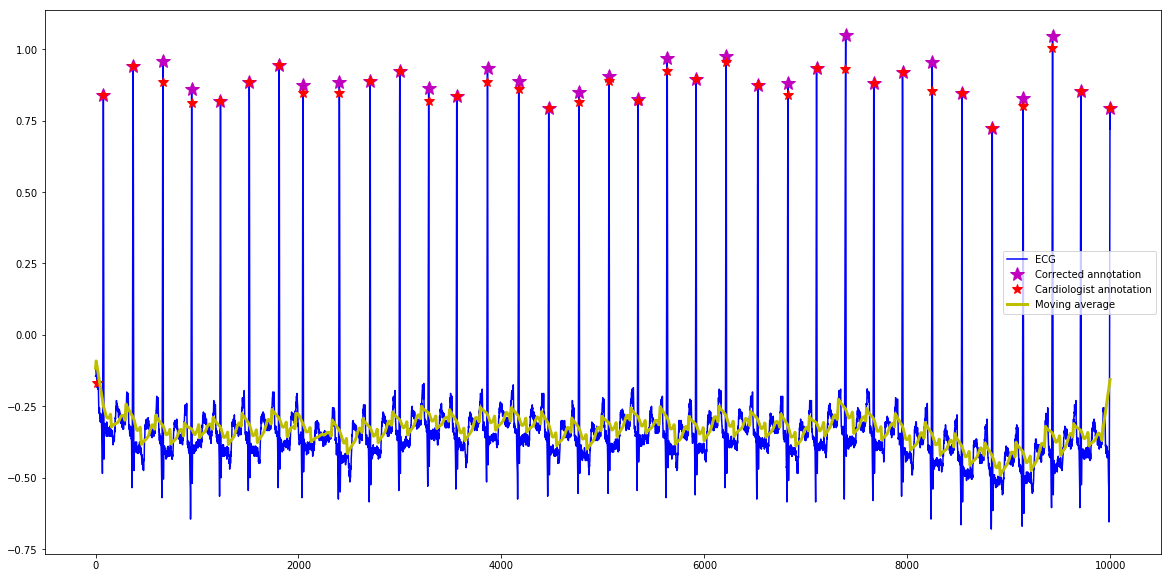

In [28]:
import wfdb
import matplotlib.pyplot as plt

t = 'data/mitdb/100'
sig, fields = wfdb.srdsamp(t, sampto=10000)
fs = fields['fs']
ann = wfdb.rdann(t, 'atr', sampto=10000)
print(fields)

x = sig[:,0]

y = numpy.zeros(len(sig))
y[ann.annsamp] = 1.0

trained_fs = 360
min_bpm = 10
max_bpm = 350
min_gap = fs*60/min_bpm
max_gap = fs*60/max_bpm

y_idxs = compute_best_peak(sig[:,0], ann.annsamp, min_gap, max_gap, smooth_window=150)

yz = numpy.zeros(len(sig))
yz[y_idxs] = 1
yz = numpy.where(yz==1)[0]
print(yz)

yy = numpy.where(y==1)[0]

plt.figure(figsize=(20, 10))
plt.plot(x, 'b', label='ECG')
plt.plot(yz, sig[yz,0], 'm*', markersize=15, label='Corrected annotation')
plt.plot(yy, sig[yy,0], 'r*', markersize=10, label='Cardiologist annotation')
plt.plot(smooth(x, 150), 'y-', linewidth=3, label='Moving average')
plt.legend(numpoints=1)
plt.show()